# [МГУ_2021_2] Тарасенко Ю.

Лучший score на public liderboard - 0.96403.

Использовались следующие features:  
    1. Выход MultinomialNB (наивный байесовский классификатор) на tf-idf представлении текста сайта.  
    2. Статистики по ключевым словам: idf, tf-idf.  
    3. Кол-во тегов: a, b, br, em, h1-h6 и т.д. + общее кол-во таких тегов.  
    4. Уровень домена сайта.  
    5. Количество слов на странице.  
    6. Коэффициент сжатия.  
    7. Кол-во внутренних ссылок.  
    8. Кол-во исходящих ссылок.  
    9. Количество слов в заголовке страниц.
    10. Наличие ссылок на сайты знакомств.  
    и т.д.
    

В качестве основного классификатора использовался CatBoost.  
Поиск гиперпараметров осуществляляся с помощью hypeopt.  
При валидации модели получено значение score - 0.98.

**20 важных признаков feature_importance catBoost:**  
nb_proba_text: 29.516546352964895  
nb_predict_text: 7.643686051487729  
avg_anchor_words_num: 5.598136894284965  
img_num: 5.427237034913143  
script_num: 5.382389946820826  
url_len: 4.109298306892532  
domain_level: 3.3553888814749544  
words_num: 3.23702781456917  
anchor_tags_num: 2.683006168061153  
keywords_num: 2.6066466332811147  
avg_word_len: 2.588521544255762  
cnt_a: 2.4528873832304727  
cnt_key_text_std: 2.2960703636091293  
cnt_tags: 2.1574629526698117  
cnt_href_in: 2.077441803610224  
compression_level: 2.0584511269120522  
cnt_key_text_median: 1.8626948663256349  
cnt_br: 1.606623916602909  
tf_idf_key_text_std: 1.4066854064169054  
desc_words_num: 1.3421272385741299  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [16]:
%%time
%cp '/content/drive/My Drive/AntiSPAM/kaggle_test_data_tab.csv.zip' '/content/'
%cp '/content/drive/My Drive/AntiSPAM/kaggle_train_data_tab.csv.zip' '/content/'
%cd '/content/'
!unzip kaggle_test_data_tab.csv.zip
!unzip kaggle_train_data_tab.csv.zip
%ls

/content
Archive:  kaggle_test_data_tab.csv.zip
  inflating: kaggle_test_data_tab.csv  
Archive:  kaggle_train_data_tab.csv.zip
  inflating: kaggle_train_data_tab.csv  
drive/                        kaggle_train_data_tab.csv
kaggle_test_data_tab.csv      kaggle_train_data_tab.csv.zip
kaggle_test_data_tab.csv.zip  sample_data/
CPU times: user 161 ms, sys: 67.6 ms, total: 228 ms
Wall time: 21.2 s


In [17]:
!rm -r /content/kaggle_test_data_tab.csv.zip
!rm -r /content/kaggle_train_data_tab.csv.zip

In [18]:
from __future__ import division

from bs4 import BeautifulSoup
import pymorphy2
import base64
import csv
import gzip
from io import BytesIO
import zlib
import numpy as np
from urllib.parse import urlparse

from collections import namedtuple

%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd

In [19]:
TRACE_NUM = 1000
import logging
import importlib
importlib.reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

def trace(items_num, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d" % items_num)
        
def trace_worker(items_num, worker_id, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d in worker_id %d" % (items_num, worker_id))

### Утилиты

In [20]:
import pickle
def save_obj(obj, name):                                                       
    with open(name + '.pkl', 'wb') as f:                                        
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)                            
                                                                                
def load_obj(name):                                                            
    with open(name + '.pkl', 'rb') as f:                                        
        return pickle.load(f) 

### Извлечение текста из html

#### Извлечение текста при помощи дополнительных библиотек

In [21]:
def html2text_bs(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста
    """
    soup = BeautifulSoup(raw_html, "html.parser")
    [s.extract() for s in soup(['script', 'style'])]
    return soup.get_text()

def html2text_bs_visible(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста, который видим пользователю
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    return soup.get_text()

#### Выбираем какой метод для конвертации html в текст будет основным

In [22]:
html2text = html2text_bs
# html2text = html2text_parser

#### Методы для токенизации текста

In [23]:
def easy_tokenizer(text):
    word = str()
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = str()
    if word: yield word

PYMORPHY_CACHE = {}
MORPH = None
#hint, чтобы установка pymorphy2 не была бы обязательной
def get_lemmatizer():
    import pymorphy2
    global MORPH
    if MORPH is None: MORPH = pymorphy2.MorphAnalyzer()
    return MORPH

def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE
    for word in easy_tokenizer(text):
        word_hash = hash(word)
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = get_lemmatizer().parse(word)[0].normal_form            
        yield PYMORPHY_CACHE[word_hash]

#### Основная функция, которая вызывается для преобразования html в список слов

In [24]:
def html2word(raw_html, to_text=html2text, tokenizer=pymorphy_tokenizer):
    return tokenizer(to_text(raw_html).lower())

### Парсинг html: выдление title, keywords, description

In [780]:
def count_tags(tags, soup):
    res = {}
    for searched_tag in tags:
        res[searched_tag] = len(soup.find_all(searched_tag))
    return res

def get_cnt_href_dating_sites(hrefs):
    dating_sites = ['mamba.ru', 'mylove.ru', 'rusdate.net', 'loveeto.ru', 'loveplanet.vip', 'teamo.ru', 'badoo.com']
    return sum([sum([str(href).lower().find(site) > 0 for site in dating_sites])
                for href in hrefs])

def get_cnt_href_in(url, hrefs):
    from urllib.parse import urlparse
    netloc = urlparse(url).netloc
    return sum([href['href'].lower().find(netloc) > 0 or
                str(href).startswith('#')
                for href in hrefs])

def get_cnt_href_out(url, hrefs):
    from urllib.parse import urlparse
    netloc = urlparse(url).netloc
    return sum([urlparse(href['href']).netloc != netloc
                for href in hrefs])

def get_domain_level(url):
    from urllib.parse import urlparse
    return len(urlparse(url).netloc.split('.'))

In [25]:
def get_html_info(raw_html):
    from bs4 import BeautifulSoup
    
    info = {}
    
    soup = BeautifulSoup(raw_html, "html.parser")
    
    info['title_meta'] = ""
    info['keywords'] = ""
    info['description'] = ""
    info['title'] = ""
    info['avg_anchor_words_num'] = 0
    
    head = soup.find("head")
    if head:
        title_tag = head.find("meta",  {"property":"og:title"})
        info['title_meta'] = title_tag["content"] if (title_tag and title_tag.has_attr('content')) else ""

        keywords_tag = head.find("meta", {"name":"keywords"})
        keywords = keywords_tag["content"] if (keywords_tag and keywords_tag.has_attr('content')) else ""
        #meta_info['keywords'] = list(pymorphy_tokenizer(keywords))
        info['keywords'] = keywords
        description_tag = head.find("meta", {"name":"description"})
        description = description_tag["content"] if (description_tag and description_tag.has_attr('content')) else ""
        info['description'] = description

    title_tag = soup.find('title')
    info['title'] = title_tag.get_text() if title_tag else ""
    
    info["cnt_href_in"] = 0
    info["cnt_href_out"] = 0
    info["cnt_href_dating_sites"] = 0
    
    a_tags = soup.find_all('a', href=True)
    info["cnt_href_in"] = get_cnt_href_in(url, a_tags)
    info["cnt_href_out"] = get_cnt_href_out(url, a_tags)
    info["cnt_href_dating_sites"] = get_cnt_href_dating_sites(a_tags)

    anchor_tags = soup.find_all('a', href=True, text=True)
    anchor_texts = list(map(lambda x: (x.get_text()), anchor_tags))
    tokenized_anchor_texts = list(map(lambda x: list(pymorphy_tokenizer(x)), anchor_texts))
    l_cnt_anchors = list(map(len, tokenized_anchor_texts))
    info['avg_anchor_words_num'] = sum(l_cnt_anchors) / len(l_cnt_anchors) if l_cnt_anchors else 0
    
    info['anchor_tags_num'] = len(anchor_tags)
    info['img_num'] = len(soup.find_all('img'))
    info['script_num'] = len(soup.find_all('script'))

    tags = ['b', 'br', 'a', 'strong', 'h1', 'h2', 'h3', 
            'h4', 'h5', 'h6', 'em', 'i']
    d_tags = count_tags(tags, soup)
    for tag in tags:
        info["cnt_" + tag] = d_tags[tag]
    info['cnt_tags'] = sum(d_tags.values())
    
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    info['text'] = soup.get_text()
    
    return info

In [781]:
def calc_features(url, html_data):
    features = {}
    
    words = list(html2word(html_data))
    features['words_num'] = len(words)
    features['avg_word_len'] = get_avg_word_len(words)
    
    html_info = get_html_info(html_data)
    features.update(html_info)

    title_l = list(pymorphy_tokenizer(features['title']))
    keywords_l = list(pymorphy_tokenizer(features['keywords']))
    desc_l = list(pymorphy_tokenizer(features['description']))
    text_l = list(pymorphy_tokenizer(features['text']))
    title_meta_l = list(pymorphy_tokenizer(features['title_meta']))

    features['title_words_num'] = len(title_l)
    features['keywords_num'] = len(keywords_l)
    features['desc_words_num'] = len(desc_l)
    features['title_meta_words_num'] = len(title_meta_l)

    features['title_char_num'] = len(' '.join(title_l))
    features['keywords_char_num'] = len(' '.join(keywords_l))
    features['desc_char_num'] = len(' '.join(desc_l))
    features['title_meta_char_num'] = len(' '.join(title_meta_l))

    features['url_len'] = len(list(url.split('/')))

    features['tokenized_text'] = ' '.join(text_l)
    features['tokenized_title'] = ' '.join(title_l)

    features['compression_level'] = get_compression_level(features['tokenized_text'])
    
    #features['html_data'] = html_data
    features['domain_level'] = get_domain_level(url)

    return features

####  Вычисление признаков

In [27]:
def get_avg_word_len(words):
    cnt_words = len(words)
    return sum(list(map(lambda w: len(w), words))) / cnt_words if cnt_words else 0

In [28]:
def get_compression_level(text):
    gzip_string = gzip.compress(text.encode())
    return len(text) / len(gzip_string)

#### Пример

In [782]:
test_html_data = u'''
<html>
<title> Заголовок Ololo </title>
спам 1 2 3
</html>
'''
test_url = 'http://ololo'
calc_features(test_url, test_html_data)

{'words_num': 6,
 'avg_word_len': 3.5,
 'title_meta': '',
 'keywords': '',
 'description': '',
 'title': ' Заголовок Ololo ',
 'avg_anchor_words_num': 0,
 'anchor_tags_num': 0,
 'img_num': 0,
 'script_num': 0,
 'text': '\n\n\nспам 1 2 3\n\n',
 'title_words_num': 2,
 'keywords_num': 0,
 'desc_words_num': 0,
 'title_meta_words_num': 0,
 'title_char_num': 15,
 'keywords_char_num': 0,
 'desc_char_num': 0,
 'title_meta_char_num': 0,
 'url_len': 3,
 'tokenized_text': 'спам 1 2 3',
 'tokenized_title': 'заголовок ololo',
 'compression_level': 0.2857142857142857,
 'domain_level': 1}

## Многопоточная обработка

In [30]:
WORKER_NUM = 4

In [31]:
from multiprocessing import Process, Queue

DocItem = namedtuple('DocItem', ['doc_id', 'is_spam', 'url', 'features'])

def load_csv(input_file_name, calc_features_f):    
    """
    Загружаем данные и извлекаем на лету признаки
    Сам контент не сохраняется, чтобы уменьшить потребление памяти - чтобы
    можно было запускать даже на ноутбуках в классе
    """
    global LAST_HTML
    with gzip.open(input_file_name, mode='rt', encoding='utf8') if input_file_name.endswith('gz') else open(input_file_name, mode='rt', encoding='utf8')  as input_file:            
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            trace(i)
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            try:
                html_data = html_data.decode('utf8')
            except:
                html_data = html_data.decode('latin1')
            features = calc_features_f(url, html_data)            
            yield DocItem(url_id, mark, url, features)            
                
        trace(i, 1)  
        
def load_csv_worker(input_file_name, calc_features_f, worker_id, res_queue):    
    with gzip.open(input_file_name,  mode='rt', encoding='utf8') if input_file_name.endswith('gz') else open(input_file_name, mode='rt', encoding='utf8')  as input_file:            
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            trace_worker(i, worker_id)
            if i % WORKER_NUM != worker_id: continue
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            try:
                html_data = html_data.decode('utf8')
            except:
                html_data = html_data.decode('latin1')
            features = calc_features_f(url, html_data)            
            res_queue.put(DocItem(url_id, mark, url, features))
                
        trace_worker(i, worker_id, 1)  
    res_queue.put(None)
        
def load_csv_multiprocess(input_file_name, calc_features_f):
    processes = []
    res_queue = Queue()    
    for i in range(WORKER_NUM):
        process = Process(target=load_csv_worker, args=(input_file_name, calc_features_f, i, res_queue))
        processes.append(process)
        process.start()
    
    complete_workers = 0
    while complete_workers != WORKER_NUM:
        item = res_queue.get()
        if item is None:
            complete_workers += 1
        else:
            yield item
        
    for process in processes: process.join()

** Обрабатываем входной файл **
<br>
Формат - поля разделенные табуляциями
<br>
0 - идентификатор документа
<br>
1 - метка класса 0 - не спам, 1 - спам
<br>
2 - урл документа
<br>
3 - документ в кодировке base64

Выходной формат - массив кортежей вида
(doc_id, is_spam, url, html_data)

In [ ]:
%%time
TRAIN_DATA_FILE  = 'kaggle_train_data_tab.csv'
train_docs = list(load_csv_multiprocess(TRAIN_DATA_FILE, calc_features))

In [145]:
#save_obj(train_docs, 'train_docs')

### Датасеты

In [32]:
train_docs = load_obj('train_docs')

In [57]:
test_docs = load_obj('test_docs')

In [44]:
doc_features = train_docs[0].features.keys()
df_columns = ['doc_id', 'target'] + [k for k in doc_features]

In [43]:
df_train = pd.concat([pd.DataFrame([[doc.doc_id, str(int(doc.is_spam))] + [doc.features[k] for k in doc_features]], 
                      columns=df_columns) 
                      for doc in train_docs], ignore_index=True)
df_train.set_index('doc_id',inplace=True)

In [58]:
df_test = pd.concat([pd.DataFrame([[doc.doc_id, str(int(doc.is_spam))] + [doc.features[k] for k in doc_features]], 
                     columns=df_columns) 
                     for doc in test_docs], ignore_index=True)
df_test.set_index('doc_id',inplace=True)

### Дополнительные признаки

In [45]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm

##### TF-IDF

In [59]:
all_texts = pd.concat([df_train['tokenized_text'], df_test['tokenized_text']])

In [61]:
all_titles = pd.concat([df_train['tokenized_title'], df_test['tokenized_title']])

In [60]:
MAX_TFIDF_FEATURES = 50_000
tf_idf_vectorizer = TfidfVectorizer(max_features=MAX_TFIDF_FEATURES, ngram_range = (1, 3))
tf_idf_vectorizer.fit(all_texts)

TfidfVectorizer(max_features=50000, ngram_range=(1, 3))

In [62]:
title_tf_idf_vectorizer = TfidfVectorizer(max_features=10_000, ngram_range = (1, 3))
title_tf_idf_vectorizer.fit(all_titles)

TfidfVectorizer(max_features=10000, ngram_range=(1, 3))

In [63]:
tf_idf_train = tf_idf_vectorizer.transform(df_train.tokenized_text)
tf_idf_test = tf_idf_vectorizer.transform(df_test.tokenized_text)

In [65]:
title_tf_idf_train = title_tf_idf_vectorizer.transform(df_train.tokenized_title)
title_tf_idf_test = title_tf_idf_vectorizer.transform(df_test.tokenized_title)

**Средний IDF по ключевым словам**

In [66]:
df_idf = pd.DataFrame(tf_idf_vectorizer.idf_, index=tf_idf_vectorizer.get_feature_names(), columns=["idf"])

In [67]:
feature_names_vectorizer = np.array(tf_idf_vectorizer.get_feature_names())

In [68]:
def fill_idf_key_text_median(df, tf_idf_matrix):
    i = 0
    for idx in tqdm(df.index):
        tf_idf_vector = np.array(tf_idf_matrix[i, :].todense()).reshape(-1)
        sorted_by_idf = np.argsort(tf_idf_vector)
        top_words = feature_names_vectorizer[sorted_by_idf[::-1][:10]]
        df.loc[idx, 'idf_key_text_median'] = df_idf.loc[top_words].idf.median()
        i += 1
        
def fill_idf_key_text_std(df, tf_idf_matrix):
    i = 0
    for idx in tqdm(df.index):
        tf_idf_vector = np.array(tf_idf_matrix[i, :].todense()).reshape(-1)
        sorted_by_idf = np.argsort(tf_idf_vector)
        top_words = feature_names_vectorizer[sorted_by_idf[::-1][:10]]
        df.loc[idx, 'idf_key_text_std'] = df_idf.loc[top_words].idf.std()
        i += 1
        
def fill_tf_idf_key_text_median(df, tf_idf_matrix):
    i = 0
    for idx in tqdm(df.index):
        tf_idf_vector = np.array(tf_idf_matrix[i, :].todense()).reshape(-1)
        sorted_by_idf = np.argsort(tf_idf_vector)
        df.loc[idx, 'tf_idf_key_text_median'] = np.median(tf_idf_vector[sorted_by_idf[::-1][:10]])
        i += 1
        
def fill_tf_idf_key_text_std(df, tf_idf_matrix):
    i = 0
    for idx in tqdm(df.index):
        tf_idf_vector = np.array(tf_idf_matrix[i, :].todense()).reshape(-1)
        sorted_by_idf = np.argsort(tf_idf_vector)
        df.loc[idx, 'tf_idf_key_text_std'] = np.std(tf_idf_vector[sorted_by_idf[::-1][:10]])
        i += 1

In [69]:
fill_idf_key_text_median(df_train, tf_idf_train)
fill_idf_key_text_std(df_train, tf_idf_train)
fill_tf_idf_key_text_median(df_train, tf_idf_train)
fill_tf_idf_key_text_std(df_train, tf_idf_train)

100%|█████████████████████████████████████████████████████████████████████████████| 7044/7044 [00:10<00:00, 642.23it/s]


In [70]:
fill_idf_key_text_median(df_test, tf_idf_test)
fill_idf_key_text_std(df_test, tf_idf_test)
fill_tf_idf_key_text_median(df_test, tf_idf_test)
fill_tf_idf_key_text_std(df_test, tf_idf_test)

100%|███████████████████████████████████████████████████████████████████████████| 16039/16039 [00:26<00:00, 614.03it/s]


**Статистики кол-ву ключевых слов в тексте**

In [71]:
count_vect = CountVectorizer(vocabulary=feature_names_vectorizer, ngram_range = (1, 3))

In [72]:
count_vect.fit(all_texts)

CountVectorizer(ngram_range=(1, 3),
                vocabulary=array(['00', '00 00', '00 01', ..., 'ўарма', 'ўейх', 'ҷонибить'],
      dtype='<U183'))

In [73]:
feature_names_count_vectorizer = np.array(count_vect.get_feature_names())

In [74]:
count_matrix_train = count_vect.transform(df_train.tokenized_text)
count_matrix_test = count_vect.transform(df_test.tokenized_text)

In [79]:
def get_cnt_key_text_median(df, cnt_matrix):
    i = 0
    for idx in tqdm(df.index):
        cnt_vector = np.array(cnt_matrix[i, :].todense()).reshape(-1)
        indices_sorted_by_cnt = np.argsort(cnt_vector)
        df.loc[idx, 'cnt_key_text_median'] = np.median(cnt_vector[indices_sorted_by_cnt[::-1][:10]])
        i += 1
        
def get_cnt_key_text_std(df, cnt_matrix):
    i = 0
    for idx in tqdm(df.index):
        cnt_vector = np.array(cnt_matrix[i, :].todense()).reshape(-1)
        indices_sorted_by_cnt = np.argsort(cnt_vector)
        df.loc[idx, 'cnt_key_text_std'] = np.std(cnt_vector[indices_sorted_by_cnt[::-1][:10]])
        i += 1

In [80]:
get_cnt_key_text_median(df_train, count_matrix_train)
get_cnt_key_text_std(df_train, count_matrix_train)

100%|█████████████████████████████████████████████████████████████████████████████| 7044/7044 [00:08<00:00, 872.68it/s]


In [81]:
get_cnt_key_text_median(df_test, count_matrix_test)
get_cnt_key_text_std(df_test, count_matrix_test)

100%|███████████████████████████████████████████████████████████████████████████| 16039/16039 [00:18<00:00, 844.78it/s]


### Анализ признаков

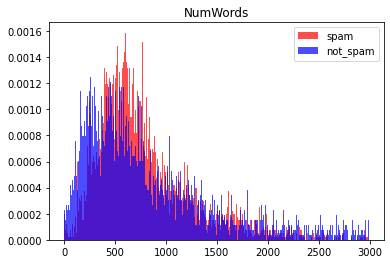

In [134]:
is_spam_data = [doc.features['words_num'] for doc in train_docs if doc.is_spam == True]
not_spam_data = [doc.features['words_num'] for doc in train_docs if doc.is_spam == False]
bins = range(0,3000,10)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('NumWords')
plt.legend()
plt.show()

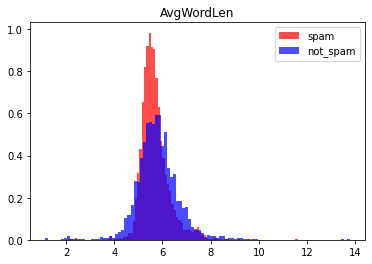

In [135]:
is_spam_data = [doc.features['avg_word_len'] for doc in train_docs if doc.is_spam == True]
not_spam_data = [doc.features['avg_word_len'] for doc in train_docs if doc.is_spam == False]
bins = 100
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('AvgWordLen')
plt.legend()
plt.show()

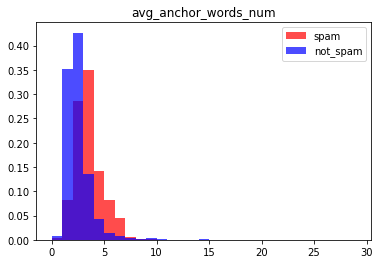

In [675]:
is_spam_data = [doc.features['avg_anchor_words_num'] for doc in train_docs if doc.is_spam == True]
not_spam_data = [doc.features['avg_anchor_words_num'] for doc in train_docs if doc.is_spam == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('avg_anchor_words_num')
plt.legend()
plt.show()

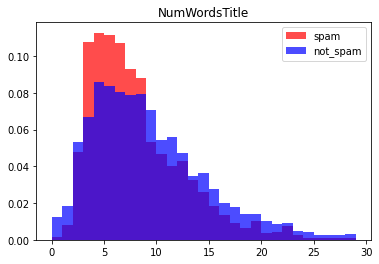

In [76]:
is_spam_data = [doc.features['title_words_num'] for doc in train_docs if doc.is_spam == True]
not_spam_data = [doc.features['title_words_num'] for doc in train_docs if doc.is_spam == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('NumWordsTitle')
plt.legend()
plt.show()

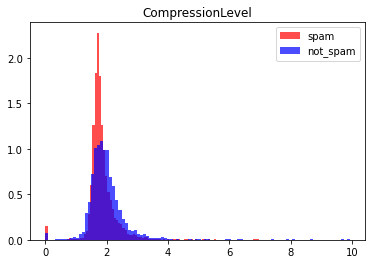

In [47]:
is_spam_data = df_train.loc[df_train['target'] == '1'][['compression_level']]
not_spam_data = df_train.loc[df_train['target'] == '0'][['compression_level']]
plt.hist(is_spam_data, bins=100, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=100, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('CompressionLevel')
plt.legend()
plt.show()

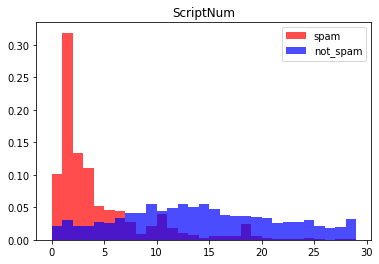

In [139]:
is_spam_data = [doc.features['script_num'] for doc in train_docs if doc.is_spam == True]
not_spam_data = [doc.features['script_num'] for doc in train_docs if doc.is_spam == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('ScriptNum')
plt.legend()
plt.show()

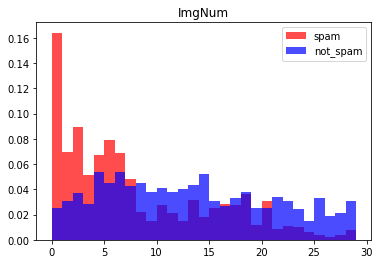

In [140]:
is_spam_data = [doc.features['img_num'] for doc in train_docs if doc.is_spam == True]
not_spam_data = [doc.features['img_num'] for doc in train_docs if doc.is_spam == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('ImgNum')
plt.legend()
plt.show()

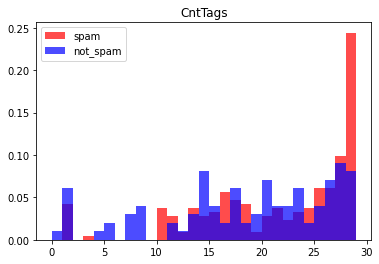

In [48]:
is_spam_data = [doc.features['cnt_tags'] for doc in train_docs if doc.is_spam == True]
not_spam_data = [doc.features['cnt_tags'] for doc in train_docs if doc.is_spam == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('CntTags')
plt.legend()
plt.show()

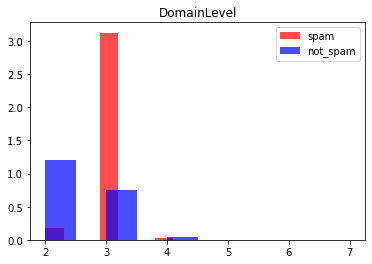

In [56]:
is_spam_data = [doc.features['domain_level'] for doc in train_docs if doc.is_spam == True]
not_spam_data = [doc.features['domain_level'] for doc in train_docs if doc.is_spam == False]
plt.hist(is_spam_data, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('DomainLevel')
plt.legend()
plt.show()

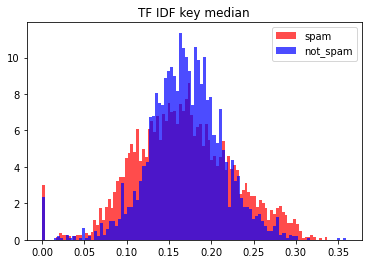

In [158]:
is_spam_data = df_train.loc[df_train['target'] == '1'][['tf_idf_key_text_median']]
not_spam_data = df_train.loc[df_train['target'] == '0'][['tf_idf_key_text_median']]
plt.hist(is_spam_data, bins=100, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=100, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('TF IDF key median')
plt.legend()
plt.show()

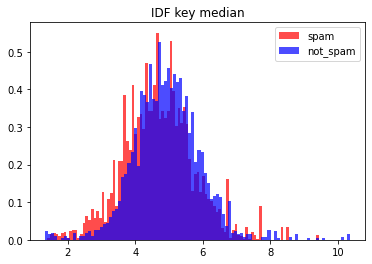

In [159]:
is_spam_data = df_train.loc[df_train['target'] == '1'][['idf_key_text_median']]
not_spam_data = df_train.loc[df_train['target'] == '0'][['idf_key_text_median']]
plt.hist(is_spam_data, bins=100, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=100, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('IDF key median')
plt.legend()
plt.show()

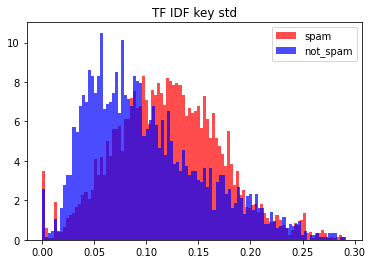

In [179]:
is_spam_data = df_train.loc[df_train['target'] == '1'][['tf_idf_key_text_std']]
not_spam_data = df_train.loc[df_train['target'] == '0'][['tf_idf_key_text_std']]
plt.hist(is_spam_data, bins=100, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=100, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('TF IDF key std')
plt.legend()
plt.show()

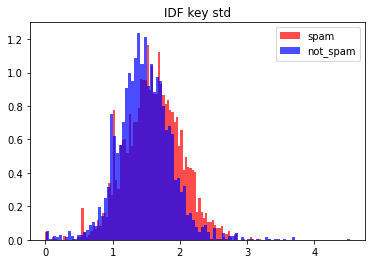

In [195]:
is_spam_data = df_train.loc[df_train['target'] == '1'][['idf_key_text_std']]
not_spam_data = df_train.loc[df_train['target'] == '0'][['idf_key_text_std']]
plt.hist(is_spam_data, bins=100, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=100, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('IDF key std')
plt.legend()
plt.show()

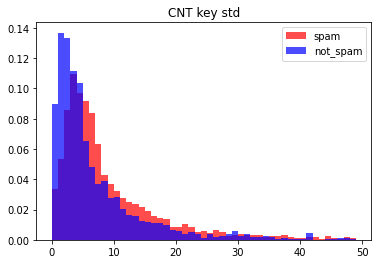

In [82]:
is_spam_data = df_train.loc[df_train['target'] == '1'][['cnt_key_text_std']]
not_spam_data = df_train.loc[df_train['target'] == '0'][['cnt_key_text_std']]
bins = range(0, 50, 1)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('CNT key std')
plt.legend()
plt.show()

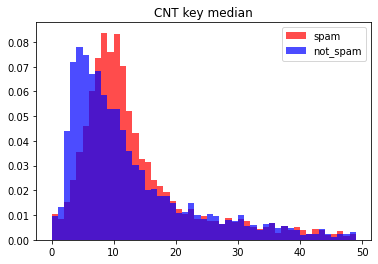

In [83]:
is_spam_data = df_train.loc[df_train['target'] == '1'][['cnt_key_text_median']]
not_spam_data = df_train.loc[df_train['target'] == '0'][['cnt_key_text_median']]
bins = range(0, 50, 1)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('CNT key median')
plt.legend()
plt.show()

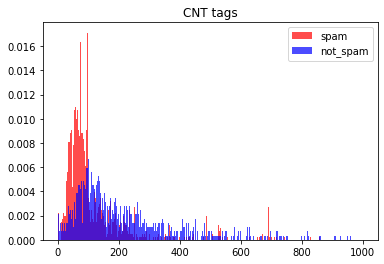

In [309]:
is_spam_data = df_train.loc[df_train['target'] == '1'][['cnt_tags']]
not_spam_data = df_train.loc[df_train['target'] == '0'][['cnt_tags']]
bins = range(0, 1000, 1)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('CNT tags')
plt.legend()
plt.show()

In [ ]:
#!pip install catboost

In [551]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
from sklearn.decomposition import TruncatedSVD
import catboost
from sklearn.ensemble import RandomForestClassifier

In [263]:
X_train, X_test, y_train, y_test = train_test_split(tf_idf_train, df_train['target'], 
                                                    test_size=0.1, random_state=69, stratify=df_train['target'])

In [264]:
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_score, recall_score, f1_score

In [265]:
%%time
svc_clf = LinearSVC(penalty="l2")
svc_clf.fit(X_train, y_train)
y_pred_svc = svc_clf.predict(X_test)
y_test_l = list(y_test.astype('str'))
print("Precision: %.3f" % precision_score(y_test_l, y_pred_svc, pos_label="1"))
print("Recall: %.3f" % recall_score(y_test_l, y_pred_svc, pos_label="1"))
print("F1: %.3f" % f1_score(y_test_l, y_pred_svc, average='weighted'))

Precision: 0.978
Recall: 0.951
F1: 0.959
Wall time: 327 ms


In [225]:
X_train_title, X_test_title, \
y_train_title, y_test_title = train_test_split(title_tf_idf_train, df_train['target'], 
                                               test_size=0.1, random_state=69, stratify=df_train['target'])

In [227]:
%%time
svc_clf_title = LinearSVC(penalty="l2")
svc_clf_title.fit(X_train_title, y_train_title)
y_pred_svc_title = svc_clf_title.predict(X_test_title)
y_test_l_title = list(y_test_title.astype('str'))
print("Precision: %.3f" % precision_score(y_test_l_title, y_pred_svc_title, pos_label="1"))
print("Recall: %.3f" % recall_score(y_test_l_title, y_pred_svc_title, pos_label="1"))
print("F1: %.3f" % f1_score(y_test_l_title, y_pred_svc_title, average='weighted'))

Precision: 0.951
Recall: 0.891
F1: 0.910
Wall time: 48 ms


In [266]:
model_nb = MultinomialNB().fit(X_train, y_train)

In [267]:
y_pred = model_nb.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.9303711986255727

In [268]:
df_train['nb_proba_text'] = model_nb.predict_proba(tf_idf_train)[:, 1]
df_train['nb_predict_text'] = model_nb.predict(tf_idf_train)
df_train['nb_predict_text'] = df_train['nb_predict_text'].astype(str)

In [269]:
df_train['svc_proba_text'] = svc_clf.decision_function(tf_idf_train)
df_train['svc_pred_text'] = svc_clf.predict(tf_idf_train)
df_train['svc_pred_text'] = df_train['svc_pred_text'].astype(str)

In [229]:
df_train['svc_proba_title'] = svc_clf_title.decision_function(title_tf_idf_train)
df_train['svc_pred_title'] = svc_clf_title.predict(title_tf_idf_train)
df_train['svc_pred_title'] = df_train['svc_pred_title'].astype(str)

In [270]:
model_nb_test = MultinomialNB().fit(tf_idf_train, df_train['target'])
svc_clf_test = LinearSVC(penalty="l2").fit(tf_idf_train, df_train['target'])

In [762]:
svc_clf_title_test = LinearSVC(penalty="l2").fit(title_tf_idf_train, df_train['target'])

In [271]:
df_test['nb_proba_text'] = model_nb_test.predict_proba(tf_idf_test)[:, 1]
df_test['nb_predict_text'] = model_nb_test.predict(tf_idf_test)
df_test['nb_predict_text'] = df_test['nb_predict_text'].astype(str)
df_test['svc_proba_text'] = svc_clf_test.decision_function(tf_idf_test)
df_test['svc_pred_text'] = svc_clf_test.predict(tf_idf_test)
df_test['svc_pred_text'] = df_test['svc_pred_text'].astype(str)

In [763]:
df_test['svc_proba_title'] = svc_clf_title_test.decision_function(title_tf_idf_test)
df_test['svc_pred_title'] = svc_clf_title_test.predict(title_tf_idf_test)
df_test['svc_pred_title'] = df_test['svc_pred_title'].astype(str)

In [745]:
df_X = df_train.copy()
df_X = df_X.drop(['title_meta', 'target', 'text', 'title', 'title_meta', 'tokenized_text',
                  'keywords', 'description', 'tokenized_title', 'keywords',
                  'description',
                  'nb_predict_text', 'nb_proba_text'], axis=1)

*Без SVC*

In [783]:
df_X = df_train.copy()
df_X = df_X.drop(['title_meta', 'target', 'text', 'title', 'title_meta', 'tokenized_text',
                  'keywords', 'description', 'tokenized_title', 'keywords',
                  'description', 'svc_proba_text', 'svc_pred_text',
                  'svc_proba_title', 'svc_pred_title'], axis=1)

In [784]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_train['target'], test_size=0.1, 
                                                    random_state=69, stratify=df_train['target'])

In [785]:
categorical_features_indices = np.where(X_train.dtypes == object)[0]

In [787]:
import hyperopt
from numpy.random import RandomState

In [790]:
params_space = {
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 2, 1),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-2, 5e-1),
    'depth': (1 + hyperopt.hp.uniform('depth', 3, 10)),
    'iterations': (1 + hyperopt.hp.uniform('iterations', 4, 50)),
    'rsm': hyperopt.hp.uniform('rsm', 0.5, 1),
    'border_count': hyperopt.hp.qloguniform('border_count', np.log(32), np.log(255), 1),
    #'leaf_estimation_method': hyperopt.hp.choice('leaf_estimation_method', ['Newton', 'Gradient']),
    'bagging_temperature': hyperopt.hp.loguniform('bagging_temperature', np.log(1), np.log(3))
}

trials = hyperopt.Trials()

In [791]:
def hyperopt_objective(params):
    model = CatBoostClassifier(thread_count=8,
                               l2_leaf_reg=int(params['l2_leaf_reg']),
                               learning_rate=params['learning_rate'],
                               iterations=int(params['iterations']),
                               depth=int(params['depth']),
                               rsm=params['rsm'],
                               border_count=int(params['border_count']),
                               #leaf_estimation_method=params['leaf_estimation_method'],
                               bagging_temperature=params['bagging_temperature'],
                               eval_metric='TotalF1',
                               use_best_model=True,
                               random_seed=42,
                               verbose=False,
                               loss_function='Logloss')
    cv_data = catboost.cv(
        catboost.Pool(X_train, y_train, cat_features=categorical_features_indices),
        model.get_params(),
        shuffle=True,
        fold_count=5,
        stratified=True)
    best_f1 = np.max(cv_data['test-TotalF1-mean'])
    
    return 1 - best_f1 # as hyperopt minimises

In [792]:
best_param = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=20,
    trials=trials,
    rstate=RandomState(123)
)

  0%|                                                                           | 0/20 [00:00<?, ?trial/s, best loss=?]

01:53:37 INFO:build_posterior_wrapper took 0.001997 seconds
01:53:37 INFO:TPE using 0 trials


  5%|██▎                                            | 1/20 [00:03<01:14,  3.91s/trial, best loss: 0.024603080587338733]

01:53:41 INFO:build_posterior_wrapper took 0.002999 seconds
01:53:41 INFO:TPE using 1/1 trials with best loss 0.024603


 10%|████▋                                          | 2/20 [00:05<00:46,  2.56s/trial, best loss: 0.024603080587338733]

01:53:42 INFO:build_posterior_wrapper took 0.002999 seconds
01:53:42 INFO:TPE using 2/2 trials with best loss 0.024603


 15%|███████                                        | 3/20 [00:05<00:27,  1.59s/trial, best loss: 0.024603080587338733]

01:53:43 INFO:build_posterior_wrapper took 0.002997 seconds
01:53:43 INFO:TPE using 3/3 trials with best loss 0.024603


 20%|█████████▍                                     | 4/20 [00:06<00:18,  1.14s/trial, best loss: 0.024603080587338733]

01:53:43 INFO:build_posterior_wrapper took 0.003051 seconds
01:53:43 INFO:TPE using 4/4 trials with best loss 0.024603


 25%|███████████▊                                   | 5/20 [00:08<00:23,  1.56s/trial, best loss: 0.024603080587338733]

01:53:45 INFO:build_posterior_wrapper took 0.001998 seconds
01:53:45 INFO:TPE using 5/5 trials with best loss 0.024603


 30%|██████████████                                 | 6/20 [00:10<00:22,  1.60s/trial, best loss: 0.024603080587338733]

01:53:47 INFO:build_posterior_wrapper took 0.002026 seconds
01:53:47 INFO:TPE using 6/6 trials with best loss 0.024603


 35%|████████████████▍                              | 7/20 [00:11<00:20,  1.57s/trial, best loss: 0.024603080587338733]

01:53:49 INFO:build_posterior_wrapper took 0.005999 seconds
01:53:49 INFO:TPE using 7/7 trials with best loss 0.024603


 40%|██████████████████▊                            | 8/20 [00:12<00:15,  1.26s/trial, best loss: 0.024603080587338733]

01:53:49 INFO:build_posterior_wrapper took 0.003000 seconds
01:53:49 INFO:TPE using 8/8 trials with best loss 0.024603


 45%|█████████████████████▏                         | 9/20 [00:20<00:36,  3.33s/trial, best loss: 0.024454414479145092]

01:53:57 INFO:build_posterior_wrapper took 0.002997 seconds
01:53:57 INFO:TPE using 9/9 trials with best loss 0.024454


 50%|███████████████████████                       | 10/20 [00:22<00:29,  2.91s/trial, best loss: 0.024454414479145092]

01:53:59 INFO:build_posterior_wrapper took 0.002035 seconds
01:53:59 INFO:TPE using 10/10 trials with best loss 0.024454


 55%|█████████████████████████▎                    | 11/20 [00:24<00:24,  2.73s/trial, best loss: 0.023034106234791962]

01:54:01 INFO:build_posterior_wrapper took 0.001999 seconds
01:54:01 INFO:TPE using 11/11 trials with best loss 0.023034


 60%|███████████████████████████▌                  | 12/20 [00:26<00:18,  2.35s/trial, best loss: 0.023034106234791962]

01:54:03 INFO:build_posterior_wrapper took 0.005998 seconds
01:54:03 INFO:TPE using 12/12 trials with best loss 0.023034


 65%|█████████████████████████████▉                | 13/20 [00:28<00:16,  2.33s/trial, best loss: 0.023034106234791962]

01:54:05 INFO:build_posterior_wrapper took 0.003003 seconds
01:54:05 INFO:TPE using 13/13 trials with best loss 0.023034


 70%|████████████████████████████████▏             | 14/20 [00:32<00:16,  2.79s/trial, best loss: 0.023034106234791962]

01:54:09 INFO:build_posterior_wrapper took 0.002000 seconds
01:54:09 INFO:TPE using 14/14 trials with best loss 0.023034


 75%|██████████████████████████████████▌           | 15/20 [00:34<00:13,  2.64s/trial, best loss: 0.023034106234791962]

01:54:11 INFO:build_posterior_wrapper took 0.002999 seconds
01:54:11 INFO:TPE using 15/15 trials with best loss 0.023034


 80%|████████████████████████████████████▊         | 16/20 [00:35<00:07,  1.98s/trial, best loss: 0.023034106234791962]

01:54:12 INFO:build_posterior_wrapper took 0.003032 seconds
01:54:12 INFO:TPE using 16/16 trials with best loss 0.023034


 85%|███████████████████████████████████████       | 17/20 [00:35<00:04,  1.64s/trial, best loss: 0.023034106234791962]

01:54:13 INFO:build_posterior_wrapper took 0.003000 seconds
01:54:13 INFO:TPE using 17/17 trials with best loss 0.023034


 90%|█████████████████████████████████████████▍    | 18/20 [00:37<00:03,  1.60s/trial, best loss: 0.023034106234791962]

01:54:14 INFO:build_posterior_wrapper took 0.002997 seconds
01:54:14 INFO:TPE using 18/18 trials with best loss 0.023034


 95%|███████████████████████████████████████████▋  | 19/20 [00:38<00:01,  1.52s/trial, best loss: 0.023034106234791962]

01:54:15 INFO:build_posterior_wrapper took 0.002041 seconds
01:54:15 INFO:TPE using 19/19 trials with best loss 0.023034


100%|██████████████████████████████████████████████| 20/20 [00:40<00:00,  2.01s/trial, best loss: 0.023034106234791962]


In [793]:
best_param

{'bagging_temperature': 1.0397673429420147,
 'border_count': 60.0,
 'depth': 7.882219755748207,
 'iterations': 37.689057053592194,
 'l2_leaf_reg': 2.0,
 'learning_rate': 0.4951481597096148,
 'rsm': 0.5133739717626367}

In [794]:
model_catboost = CatBoostClassifier(thread_count=8,
                                    iterations=int(best_param['iterations']),
                                    l2_leaf_reg = int(best_param['l2_leaf_reg']), 
                                    learning_rate = best_param['learning_rate'],
                                    max_depth=int(best_param['depth']),
                                    rsm=best_param['rsm'],
                                    border_count=int(best_param['border_count']),
                                    #leaf_estimation_method=best_param['leaf_estimation_method'],
                                    bagging_temperature=best_param['bagging_temperature'])
model_catboost.fit(X_train, y_train, cat_features=categorical_features_indices, verbose=False, plot=False)

In [795]:
y_pred_cb = model_catboost.predict(X_test)
f1_score(y_test, y_pred_cb, average='weighted')

0.9815733126241821

In [796]:
feature_importances = model_catboost.get_feature_importance()
feature_names = X_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True)[:20]:
    print('{}: {}'.format(name, score))

nb_proba_text: 29.516546352964895
nb_predict_text: 7.643686051487729
avg_anchor_words_num: 5.598136894284965
img_num: 5.427237034913143
script_num: 5.382389946820826
url_len: 4.109298306892532
domain_level: 3.3553888814749544
words_num: 3.23702781456917
anchor_tags_num: 2.683006168061153
keywords_num: 2.6066466332811147
avg_word_len: 2.588521544255762
cnt_a: 2.4528873832304727
cnt_key_text_std: 2.2960703636091293
cnt_tags: 2.1574629526698117
cnt_href_in: 2.077441803610224
compression_level: 2.0584511269120522
cnt_key_text_median: 1.8626948663256349
cnt_br: 1.606623916602909
tf_idf_key_text_std: 1.4066854064169054
desc_words_num: 1.3421272385741299


In [732]:
df_X_test = df_test.copy()
df_X_test = df_X_test.drop(['title_meta', 'target', 'text', 'title', 'title_meta', 'tokenized_text',
                            'keywords', 'description', 'tokenized_title', 'keywords',
                            'description', 'svc_proba_text', 'svc_pred_text'], axis=1)

In [774]:
model_catboost_test = CatBoostClassifier(thread_count=8,
                                         iterations=int(best_param['iterations']),
                                         l2_leaf_reg = int(best_param['l2_leaf_reg']), 
                                         learning_rate = best_param['learning_rate'],
                                         max_depth=int(best_param['depth']),
                                         rsm=best_param['rsm'],
                                         border_count=int(best_param['border_count']),
                                         bagging_temperature=best_param['bagging_temperature'])
model_catboost_test.fit(df_X, df_train['target'], cat_features=categorical_features_indices, 
                        verbose=False, plot=False)

In [775]:
y_pred_cb = model_catboost_test.predict(df_X_test)

In [776]:
df_X_test['target'] = y_pred_cb

In [777]:
df_X_test = df_X_test.rename(columns={"target": "Prediction"})

In [778]:
df_X_test['Id'] = df_X_test.index

In [779]:
%%time
df_X_test[['Id', 'Prediction']].to_csv("my_submission.csv", index=False)

Wall time: 39 ms
